# Mass Recalibration in CoreMS

This notebook applies Will Kew's CoreMS mass recalibration notebook to a test sample from the new scimaX instrument

[Section 1](#Section-1---Basic-Manual-Mass-Recalibration) addresses a visual inspection of the data and manual definition of the calibration thresholds.  
[Section 2](#Section-2----Segmented-Mass-Recalibration) addresses a segemented mass recalibration.  
[Section 3](#Section-3---Automatic-Calibration-based-on-Reference-Mass-List) addresses an automated mass recalibration method based on using the 'nearest' matches to the reference mass list.  
[Section 4](#Section-4---Automatic-recalibration-based-on-assignments) addresses a fully automated mass recalibration based on assigning the data and automating the steps in Section 1.


### Section 1 - Basic Manual Mass Recalibration


First, lets load in an example dataset


In [8]:
import os
import sys
from dotenv import load_dotenv
from pathlib import Path

# Import CoreMS modules for reading Bruker ICR data and setting MS Parameters
# as well as calibration and formula searches
from corems.transient.input.brukerSolarix import ReadBrukerSolarix
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas

# Import a plotting library for visualisation
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

In [12]:
# Load environment variables from .env file
load_dotenv()

# Build database URL from environment variables
db_url = os.getenv("COREMS_DATABASE_URL")

In [5]:
sys.path.append("../../")
# data_path = Path(os.getenv("COREMS_DATA_PATH", "/home/corems/data"))
data_path = Path.cwd() / "tests/tests_data"

# Provide the file location
# datafile = "../../tests/tests_data/ftms/NEG_ESI_SRFA_Auto.d"
datafile = data_path / "ftms" / "NEG_ESI_SRFA_Auto.d"
print(datafile)

/home/corems/tests/tests_data/ftms/NEG_ESI_SRFA_Auto.d


In [6]:
# Initiate the bruker reader object
bruker_reader = ReadBrukerSolarix(datafile)

# Set the noise thresholding method
MSParameters.mass_spectrum.noise_threshold_method = "log"
MSParameters.mass_spectrum.noise_threshold_log_nsigma = 10


# Process the spectrum and return the mass spectrum object
mass_spectrum = bruker_reader.get_transient().get_mass_spectrum(
    plot_result=False, auto_process=True
)
print("There were " + str(len(mass_spectrum)) + " peaks detected.")

There were 10082 peaks detected.


Now we will attempt to do formula assignment on these data before any recalibration


In [10]:
# Set some formula search rules - CHO only
mass_spectrum.molecular_search_settings.min_ppm_error = -7.5
mass_spectrum.molecular_search_settings.max_ppm_error = 7.5
mass_spectrum.molecular_search_settings.usedAtoms["C"] = (1, 90)
mass_spectrum.molecular_search_settings.usedAtoms["H"] = (4, 200)
mass_spectrum.molecular_search_settings.usedAtoms["O"] = (1, 23)
mass_spectrum.molecular_search_settings.isProtonated = Tru

# Set the database URL for formula searching 
mass_spectrum.molecular_search_settings.url_database = db_url
# If you do not have Postgres in a Docker container, you would set that to = None, e.g.
#         mass_spectrum.molecular_search_settings.url_database = None

# Now search for molecular formulas
SearchMolecularFormulas(mass_spectrum, first_hit=True).run_worker_mass_spectrum()


'runworker'  473.99 ms


Loading molecular formula database: 24326it [00:01, 14260.63it/s]
Started molecular formula search for class {"O": 23}, (de)protonated : 100%|██████████| 23/23 [00:02<00:00, 10.55it/s]


'run_molecular_formula'  4446.62 ms


In [13]:
# How many peaks were assigned
mass_spectrum.percentile_assigned()

7005 assigned peaks and 3077 unassigned peaks , total  = 69.48 %, relative abundance = 89.36 %


(7005, 3077, 69.48026185280698, 89.36162253382773)

In [16]:
# Lets visualise the assignments
# First export to a dataframe:
ms_df = mass_spectrum.to_dataframe()
ms_df.head()

,Index,m/z,Calibrated m/z,Calculated m/z,Peak Height,Peak Area,Resolving Power,S/N,Ion Charge,m/z Error (ppm),...,Is Isotopologue,Mono Isotopic Index,Molecular Formula,KMD,Formula KMD,C,H,O,13C,18O
0,1,141.019504,141.019504,141.019332,4.895988e+06,260.596149,2.055031e+06,16.748959,-1,1.215852,...,0.0,NaN,C6 H6 O4,-0.8620,-0.8619,6.0,6.0,4.0,NaN,NaN
1,22,169.014299,169.014299,169.014247,3.029041e+06,244.205339,1.715022e+06,10.547956,-1,0.308212,...,0.0,NaN,C7 H6 O5,-0.8256,-0.8255,7.0,6.0,5.0,NaN,NaN
2,23,169.014634,169.014634,169.014247,4.580403e+06,535.473453,1.371894e+06,15.693469,-1,2.288102,...,0.0,NaN,C7 H6 O5,-0.8259,-0.8255,7.0,6.0,5.0,NaN,NaN
3,41,179.035029,179.035029,179.034982,3.465008e+06,392.392713,1.295339e+06,11.818710,-1,0.261441,...,0.0,NaN,C9 H8 O4,-0.8351,-0.8351,9.0,8.0,4.0,NaN,NaN
4,42,181.014297,181.014297,181.014247,6.811310e+06,673.341266,1.601328e+06,22.748587,-1,0.278389,...,0.0,NaN,C8 H6 O5,-0.8122,-0.8121,8.0,6.0,5.0,NaN,NaN


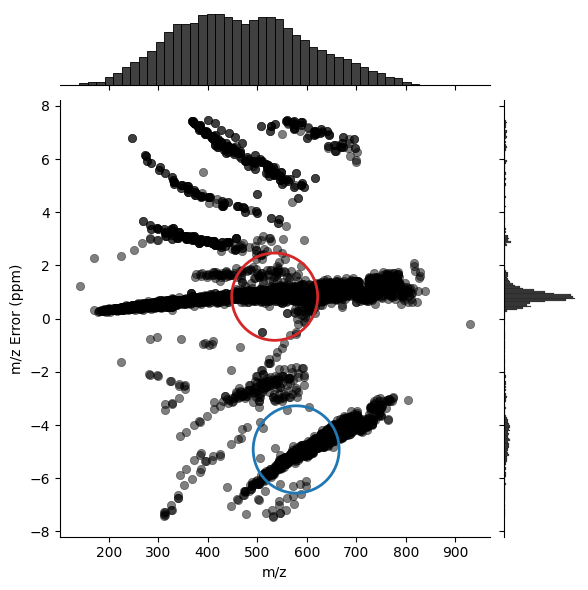

In [17]:
# Now plot the m/z error vs m/z
g = sns.jointplot(
    x="m/z",
    y="m/z Error (ppm)",
    data=ms_df,
    color="k",
    joint_kws={"edgecolor": None, "alpha": 0.5},
)

e2 = patches.Circle(
    (0.5, 0.55),
    radius=0.1,
    color="tab:red",
    linewidth=2,
    fill=False,
    zorder=2,
    transform=g.ax_joint.transAxes,
)

e3 = patches.Circle(
    (0.55, 0.20),
    radius=0.1,
    color="tab:blue",
    linewidth=2,
    fill=False,
    zorder=2,
    transform=g.ax_joint.transAxes,
)

g.ax_joint.add_patch(e2)
g.ax_joint.add_patch(e3)


Clearly in the above figure there are several distributions of errors, but - assuming the data are of OK quality - only one can be correct, the others are incorrectly assigned.

So, lets plot the Van Krevelen diagrams of the red and blue distributions (approximately)


Text(0.5, 1.0, 'Region 2')

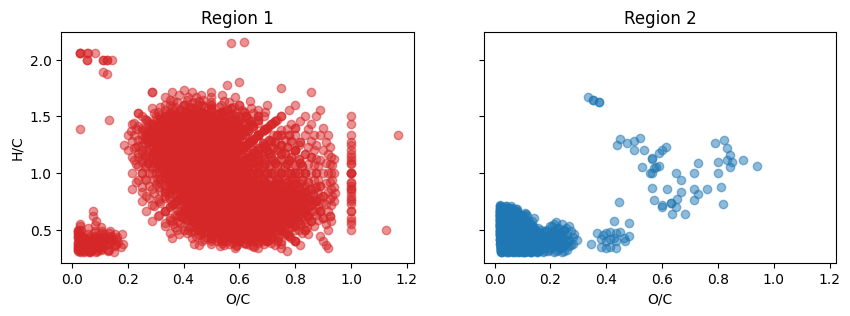

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharex=True, sharey=True)
# region 1
r1 = ms_df[(ms_df["m/z Error (ppm)"] > 0) & (ms_df["m/z Error (ppm)"] < 2)]
axes[0].scatter(x=r1["O/C"], y=r1["H/C"], c="tab:red", alpha=0.5)
# region 2
r2 = ms_df[(ms_df["m/z Error (ppm)"] < -2) & (ms_df["m/z Error (ppm)"] > -6)]
axes[1].scatter(x=r2["O/C"], y=r2["H/C"], c="tab:blue", alpha=0.5)

for ax in axes:
    ax.set_xlabel("O/C")
axes[0].set_ylabel("H/C")
axes[0].set_title("Region 1")
axes[1].set_title("Region 2")

Clearly, region 1 is the 'correct' region, and so we can recalibrate the data within those constraints


In [33]:
# Define the location of our reference mass list
# refmasslist = "Hawkes_neg.ref"
ref_data_path = Path.cwd() / "data/reference_masses"
refmasslist = ref_data_path / "Hawkes_neg.ref"
print(refmasslist)

/home/corems/data/reference_masses/Hawkes_neg.ref


In [22]:
# Define the mass calibration settings:
mass_spectrum.settings.calib_sn_threshold = 20
mass_spectrum.settings.max_calib_ppm_error = 2
mass_spectrum.settings.min_calib_ppm_error = 0
mass_spectrum.settings.calib_pol_order = 2

MzDomainCalibration(mass_spectrum, refmasslist).run()

MS Obj loaded - 10082 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
731 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.138 ppm
minimize function performed 271 fn evals and 6 iterations


/home/corems/corems/mass_spectrum/calc/Calibration.py:69: UserWarning: Warning: calibrating spectra which have already been assigned may yield erroneous results
  warnings.warn(


In [23]:
# Clear previous formula assignments
mass_spectrum.clear_molecular_formulas()

# Update threshold for assignments
mass_spectrum.molecular_search_settings.min_ppm_error = -0.75
mass_spectrum.molecular_search_settings.max_ppm_error = 0.75

# Redo the CHO search
SearchMolecularFormulas(mass_spectrum, first_hit=True).run_worker_mass_spectrum()

mass_spectrum.percentile_assigned()

'runworker'  515.81 ms


Loading molecular formula database: 24326it [00:01, 14361.63it/s]
Started molecular formula search for class {"O": 23}, (de)protonated : 100%|██████████| 23/23 [00:02<00:00,  9.01it/s]


'run_molecular_formula'  4841.36 ms
5389 assigned peaks and 4693 unassigned peaks , total  = 53.45 %, relative abundance = 84.41 %


(5389, 4693, 53.45169609204523, 84.41056911349402)

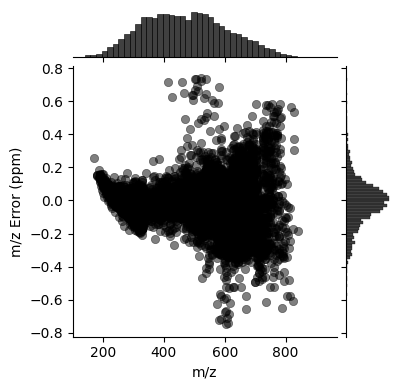

In [27]:
# Lets visualise the assignments
# First export to a dataframe:
ms_df = mass_spectrum.to_dataframe()

# Now plot the m/z error vs m/z
g = sns.jointplot(
    x="m/z",
    y="m/z Error (ppm)",
    data=ms_df,
    color="k",
    height=4,
    joint_kws={"edgecolor": None, "alpha": 0.5},
)


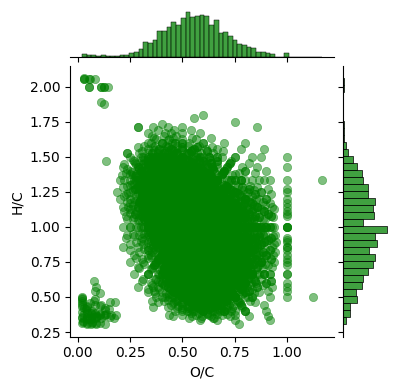

In [30]:
f = sns.jointplot(
    x="O/C",
    y="H/C",
    data=ms_df,
    color="green",
    height=4,
    joint_kws={"edgecolor": None, "alpha": 0.5},
)

### Section 2 -- Segmented Mass Recalibration


In [31]:
# The output above in van krevelen space looks good,
# but the errors are a little disperse

# Maybe we can take advantage of the new 'segmented' mass calibration.

# First, lets reload the mass spectrum object

# Process the spectrum and return the mass spectrum object
mass_spectrum = bruker_reader.get_transient().get_mass_spectrum(
    plot_result=False, auto_process=True
)


In [34]:
# Define the mass calibration settings:
mass_spectrum.settings.calib_sn_threshold = 20
mass_spectrum.settings.max_calib_ppm_error = 2
mass_spectrum.settings.min_calib_ppm_error = 0
mass_spectrum.settings.calib_pol_order = 2

MzDomainCalibration(mass_spectrum, refmasslist, mzsegment=[0, 375]).run()

MzDomainCalibration(mass_spectrum, refmasslist, mzsegment=[375, 1000]).run()


MS Obj loaded - 10082 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
187 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.049 ppm
minimize function performed 283 fn evals and 6 iterations
MS Obj loaded - 10082 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
544 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.155 ppm
minimize function performed 271 fn evals and 6 iterations


'runworker'  928.31 ms


Loading molecular formula database: 24326it [00:01, 12660.56it/s]
Started molecular formula search for class {"O": 23}, (de)protonated : 100%|██████████| 23/23 [00:02<00:00,  9.18it/s]


'run_molecular_formula'  5469.69 ms
5389 assigned peaks and 4693 unassigned peaks , total  = 53.45 %, relative abundance = 84.41 %


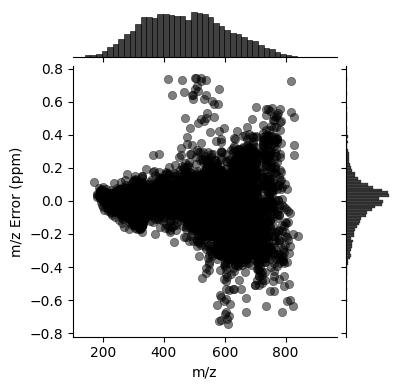

In [35]:
# Update threshold for assignment
mass_spectrum.molecular_search_settings.min_ppm_error = -0.75
mass_spectrum.molecular_search_settings.max_ppm_error = 0.75

# Redo the CHO search
SearchMolecularFormulas(mass_spectrum, first_hit=True).run_worker_mass_spectrum()

mass_spectrum.percentile_assigned()
# Lets visualise the assignments
# First export to a dataframe:
ms_df = mass_spectrum.to_dataframe()

# Now plot the m/z error vs m/z
g = sns.jointplot(
    x="m/z",
    y="m/z Error (ppm)",
    data=ms_df,
    color="k",
    height=4,
    joint_kws={"edgecolor": None, "alpha": 0.5},
)


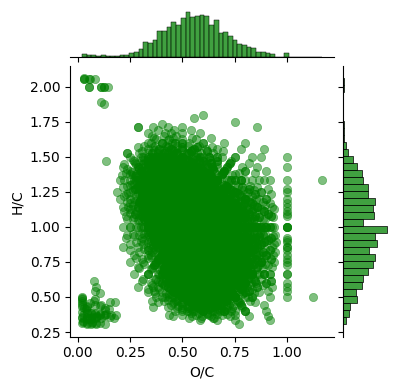

In [37]:
f = sns.jointplot(
    x="O/C",
    y="H/C",
    data=ms_df,
    color="green",
    height=4,
    joint_kws={"edgecolor": None, "alpha": 0.5},
)

### Section 3 - Automatic Calibration based on Reference Mass List


In [38]:
# First, lets reload the mass spectrum object
# Process the spectrum and return the mass spectrum object
mass_spectrum = bruker_reader.get_transient().get_mass_spectrum(
    plot_result=False, auto_process=True
)

In [39]:
# Now lets define to use the new 'merged' calibration method:
# Note, the old (original) method is available with 'legacy' call.
MSParameters.mass_spectrum.calibration_ref_match_method = "merged"
MSParameters.mass_spectrum.calibration_ref_match_tolerance = 0.003
MzDomainCalibration(mass_spectrum, refmasslist).run()

MS Obj loaded - 10082 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
586 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.073 ppm
minimize function performed 553 fn evals and 14 iterations


In [43]:
# And now assign the recalibrated data
# Update threshold for assignment
mass_spectrum.molecular_search_settings.min_ppm_error = -0.75
mass_spectrum.molecular_search_settings.max_ppm_error = 0.75

# Redo the CHO search
SearchMolecularFormulas(mass_spectrum, first_hit=True).run_worker_mass_spectrum()

mass_spectrum.percentile_assigned()


'runworker'  451.08 ms


Loading molecular formula database: 24326it [00:01, 13233.57it/s]
Started molecular formula search for class {"O": 23}, (de)protonated : 100%|██████████| 23/23 [00:00<00:00, 24.22it/s]


'run_molecular_formula'  3350.64 ms
5378 assigned peaks and 4704 unassigned peaks , total  = 53.34 %, relative abundance = 84.38 %


(5378, 4704, 53.34259075580242, 84.37980455645781)

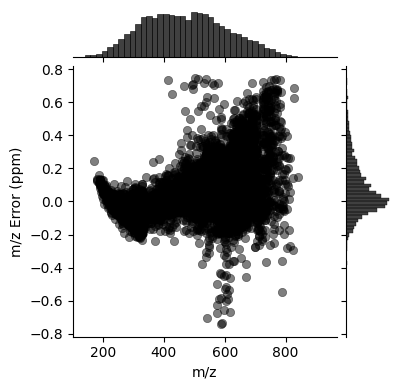

In [44]:
# Lets visualise the assignments
# First export to a dataframe:
ms_df = mass_spectrum.to_dataframe()

# Now plot the m/z error vs m/z
g = sns.jointplot(
    x="m/z",
    y="m/z Error (ppm)",
    data=ms_df,
    color="k",
    height=4,
    joint_kws={"edgecolor": None, "alpha": 0.5},
)

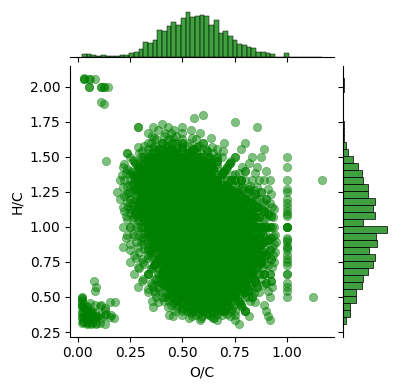

In [42]:
f = sns.jointplot(
    x="O/C",
    y="H/C",
    data=ms_df,
    color="green",
    height=4,
    joint_kws={"edgecolor": None, "alpha": 0.5},
)

### Section 4 - Automatic recalibration based on assignments


In [45]:
# Again, reload the dataset
# First, lets reload the mass spectrum object
# Process the spectrum and return the mass spectrum object
mass_spectrum = bruker_reader.get_transient().get_mass_spectrum(
    plot_result=False, auto_process=True
)

In [46]:
# Import the class for automatic recalibration based on assignments
from corems.mass_spectrum.calc.AutoRecalibration import HighResRecalibration


In [47]:
# This class is initialised with a few options, you must pass the mass spectrum object first.
# plot= true - will plot the models for the automatic determination of the error boundaries.
# docker - uses docker for formula assignment (else, uses sqlite).
# ppmFWHMprior - estimate the spread of mass errors in the raw data.
# ppmRangeprior - estimate possible range of mass error medians (e.g. 15 = +-7.5).
autorecaler = HighResRecalibration(
    mass_spectrum, plot=True, docker=True, ppmFWHMprior=3, ppmRangeprior=15
)

'runworker'  741.87 ms


Loading molecular formula database: 25098it [00:01, 14888.04it/s]
Started molecular formula search for class {"O": 23}, (de)protonated : 100%|██████████| 23/23 [00:02<00:00,  8.93it/s]


'run_molecular_formula'  5081.26 ms


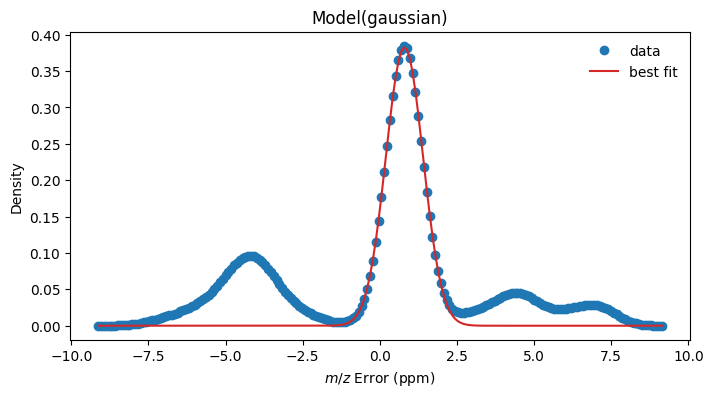

In [48]:
auto_cal_boundaries = autorecaler.determine_error_boundaries()

In [49]:
print(
    f"Raw error center: {auto_cal_boundaries[0]:.2f} ppm, \nRaw error standard FWHM: {auto_cal_boundaries[1]:.2f} ppm, \nSuggested bounds based on mean error +- fwhm: {auto_cal_boundaries[2][0]:.2f} to {auto_cal_boundaries[2][1]:.2f} ppm"
)

Raw error center: 0.80 ppm, 
Raw error standard FWHM: 1.42 ppm, 
Suggested bounds based on mean error +- fwhm: -0.62 to 2.22 ppm


In [50]:
# Now recalibrate the data based on those bounds:
# Define the mass calibration settings:
# Use the original/legacy method for matching reference masses.
MSParameters.mass_spectrum.calibration_ref_match_method = "legacy"
mass_spectrum.settings.calib_sn_threshold = 20
mass_spectrum.settings.max_calib_ppm_error = max(auto_cal_boundaries[2])
mass_spectrum.settings.min_calib_ppm_error = min(auto_cal_boundaries[2])
mass_spectrum.settings.calib_pol_order = 2

MzDomainCalibration(mass_spectrum, refmasslist).run()

MS Obj loaded - 10082 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
612 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.108 ppm
minimize function performed 307 fn evals and 7 iterations


In [51]:
# And now assign the recalibrated data
# Update threshold for assignment
mass_spectrum.molecular_search_settings.min_ppm_error = -0.75
mass_spectrum.molecular_search_settings.max_ppm_error = 0.75
mass_spectrum.molecular_search_settings.usedAtoms["C"] = (1, 90)
mass_spectrum.molecular_search_settings.usedAtoms["H"] = (4, 200)
mass_spectrum.molecular_search_settings.usedAtoms["O"] = (1, 23)
mass_spectrum.molecular_search_settings.isProtonated = True

# Redo the CHO search
SearchMolecularFormulas(mass_spectrum, first_hit=True).run_worker_mass_spectrum()

mass_spectrum.percentile_assigned()

'runworker'  582.30 ms


Loading molecular formula database: 24326it [00:01, 12966.53it/s]
Started molecular formula search for class {"O": 23}, (de)protonated : 100%|██████████| 23/23 [00:02<00:00,  7.75it/s]


'run_molecular_formula'  5525.51 ms
5391 assigned peaks and 4691 unassigned peaks , total  = 53.47 %, relative abundance = 84.41 %


(5391, 4691, 53.47153342590756, 84.41460914594148)

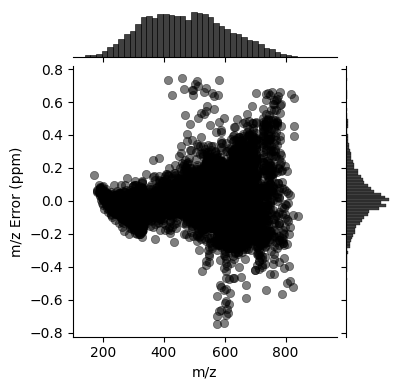

In [52]:
# Lets visualise the assignments
# First export to a dataframe:
ms_df = mass_spectrum.to_dataframe()

# Now plot the m/z error vs m/z
g = sns.jointplot(
    x="m/z",
    y="m/z Error (ppm)",
    data=ms_df,
    color="k",
    height=4,
    joint_kws={"edgecolor": None, "alpha": 0.5},
)


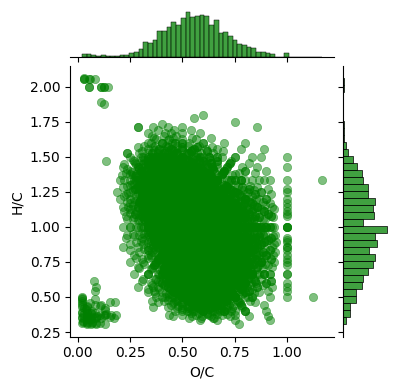

In [53]:
f = sns.jointplot(
    x="O/C",
    y="H/C",
    data=ms_df,
    color="green",
    height=4,
    joint_kws={"edgecolor": None, "alpha": 0.5},
)

In [55]:
from corems.molecular_id.factory.classification import HeteroatomsClassification

mass_spectrum_by_classes = HeteroatomsClassification(
    mass_spectrum, choose_molecular_formula=True
)


<Axes: xlabel='$\t{m/z}$', ylabel='Abundance'>

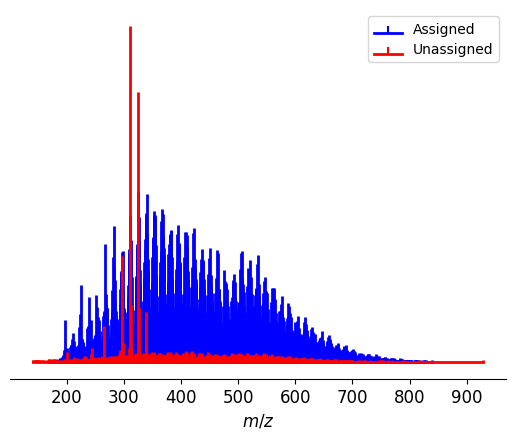

In [56]:
mass_spectrum_by_classes.plot_ms_assigned_unassigned()


<Axes: title={'center': 'Van Krevelen Diagram - All Assigned Classes'}, xlabel='O/C', ylabel='H/C'>

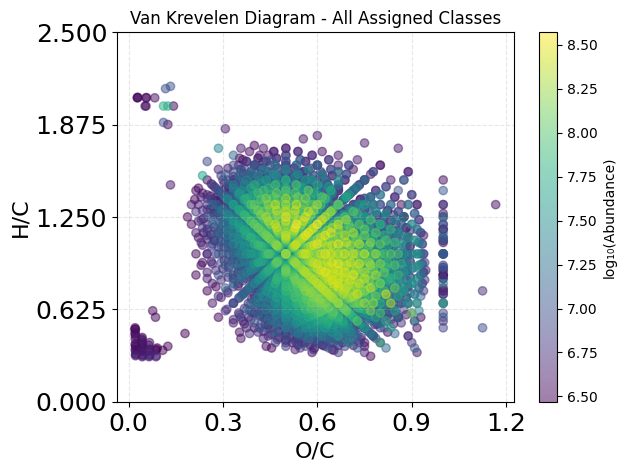

In [57]:
mass_spectrum_by_classes.plot_van_krevelen(log_abundance=True, max_oc=1.2)